In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
import h5py 
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time


from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer
from qiskit_machine_learning.circuit.library import RawFeatureVector

from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes,EfficientSU2
from sklearn.utils import shuffle
import pandas as pd

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay


In [2]:
def callback_graph(weights, obj_func_eval):
    print(len(objective_func_vals))
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
    
def produceDataset(inputFileName,path,treeName):
    
    print("start preparing",inputFileName)
    file = uproot.open(path+inputFileName+".root")
    tree=file[treeName]
    VariableList=tree.keys()
    

    df = tree.arrays(filter_name=VariableList[0],library="pd") 
    for i in range(1,len(VariableList)):
        df=df.join(tree.arrays(filter_name=VariableList[i],library="pd"))



    return df

def getFourVector(pt,eta,phi):
   
    m=1 # precision issues. not sure why but m=1 makes that no negative invariant mass square.
    px=pt*np.cos(phi)
    py=pt*np.sin(phi)
    pz=pt*np.sinh(eta)
    E=np.sqrt(px**2+py**2+pz**2+m**2)
    return np.array([E,px,py,pz], dtype=np.float64)

def getInvM(v):
    m2=v[0]**2-v[1]**2-v[2]**2-v[3]**2
    
    return np.sqrt(m2)

def getMass(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    v=v1+v2+v3+v4
    m_reco=getInvM(v)
    return m_reco

def getThreeVectors_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    

    output=np.concatenate([v1[1:],v2[1:],v3[1:],v4[1:]])
    return  np.transpose(output)

def getDot_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    
    dot=[]

#     dot.append(getInvM(v1+v1))
#     dot.append(getInvM(v2+v2))
#     dot.append(getInvM(v3+v3))
#     dot.append(getInvM(v4+v4))
    
    dot.append(getInvM(v1+v2))
    dot.append(getInvM(v1+v3))
    dot.append(getInvM(v1+v4))
    dot.append(getInvM(v2+v3))
    dot.append(getInvM(v2+v4))
    dot.append(getInvM(v3+v4))
    dot=np.array(dot)
    

    return np.transpose(dot)
    

In [3]:

nShots=2**12
nMaxIter=300
maxDatasetEvents=5000

Dir="/Users/lizhelun/Desktop/QC/Datasets/"

h4l_VV="ntuple_4mu_VV"
h4l_bkg="ntuple_4mu_bkg"

print("nShots = ",nShots)

nShots =  4096


In [4]:
h4l=produceDataset(h4l_VV,Dir,'HZZ4LeptonsAnalysisReduced')
bkg=produceDataset(h4l_bkg,Dir,'HZZ4LeptonsAnalysisReduced')

start preparing ntuple_4mu_VV
start preparing ntuple_4mu_bkg


In [5]:
m_reco_signal=getMass(h4l)
m_reco_bkg=getMass(bkg)

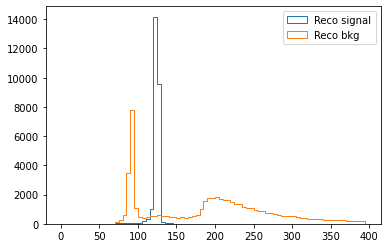

In [6]:
#h4l['f_mass4l'].hist(bins=np.arange(100,150,1),label='truth');
plt.hist(m_reco_signal,bins=np.arange(0,400,5),histtype='step',label='Reco signal');
plt.hist(m_reco_bkg,bins=np.arange(0,400,5),histtype='step',label='Reco bkg');
plt.legend()

In [7]:
# #remove large invM
# bkg=bkg[m_reco_bkg<150]

In [8]:
sig_3vec=getThreeVectors_df(h4l)
bkg_3vec=getThreeVectors_df(bkg)

In [9]:
sig_dot=getDot_df(h4l)
bkg_dot=getDot_df(bkg)

In [10]:
def split(X,y,normalize=True):
    train_ratio=0.6
    X_train, X_valTest, y_train, y_valTest = train_test_split(X.copy(), y.copy(), train_size=train_ratio, random_state=100)
    X_val, X_test, y_val, y_test = train_test_split(X_valTest, y_valTest, test_size=0.5, random_state=200)
    #Normalizing everythings:
    if normalize:
        Max=X_train.max()
        X_train=X_train/Max
        X_val=X_val/Max
        X_test=X_test/Max
        
    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [11]:
X_3=np.concatenate([sig_3vec[0:maxDatasetEvents],bkg_3vec[0:maxDatasetEvents]])
y_3=np.concatenate([np.ones(sig_3vec[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_3vec[0:maxDatasetEvents].shape[0])])
X_3,y_3=shuffle(X_3,y_3,random_state=1000)

X_train_3,y_train_3,X_val_3,y_val_3,X_test_3,y_test_3=split(X_3,y_3)

In [12]:
X_dot=np.concatenate([sig_dot[0:maxDatasetEvents],bkg_dot[0:maxDatasetEvents]])
y_dot=np.concatenate([np.ones(sig_dot[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_dot[0:maxDatasetEvents].shape[0])])
X_dot,y_dot=shuffle(X_dot,y_dot,random_state=1000)

X_train_dot,y_train_dot,X_val_dot,y_val_dot,X_test_dot,y_test_dot=split(X_dot,y_dot)

In [13]:
inv_dot=np.concatenate([m_reco_signal[0:maxDatasetEvents],m_reco_bkg[0:maxDatasetEvents]])
inv_dot=shuffle(inv_dot,random_state=1000)
inv_dot_train,inv_doty_train_3,inv_dot_val,inv_doty_val,inv_dot_test,inv_doty_test_3=split(inv_dot,y_3,normalize=False)

In [14]:
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit.circuit import ParameterVector

from qiskit.quantum_info import SparsePauliOp

from qiskit_machine_learning.neural_networks import EstimatorQNN

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR


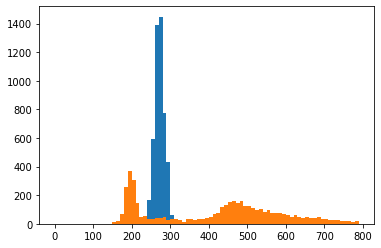

In [15]:
plt.hist(sig_dot[0:maxDatasetEvents].sum(axis=1),bins=np.arange(0,800,10));
plt.hist(bkg_dot[0:maxDatasetEvents].sum(axis=1),bins=np.arange(0,800,10));

In [16]:
#regressor:

def getEstimator(num_layers,N_particles):

    n_params=num_layers*2
    num_qubits=int((N_particles-1)*N_particles/2)

    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
    weights = ParameterVector("weight", n_params)
    print(f"weight parameters: {[str(item) for item in weights.params]}")

    inputParams_index=0
    params_index=0

    qc.compose(feature_map, inplace=True) 

    for layer in range(num_layers):

            for j in np.arange(0,num_qubits,1):
                qc.ry(weights[params_index],j)

            params_index += 1

            for i in np.arange(0,num_qubits,1):
                for k in np.arange(i,num_qubits,1):
                    if i!=k:
                        qc.rzz(weights[params_index],i,k)

            params_index += 1

            qc.barrier()

    observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
    estimator_qnn_rotPerm = EstimatorQNN(
        circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
    )
    return estimator_qnn_rotPerm

In [17]:
estimator_qnn_rotPerm=getEstimator(2,4)

weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


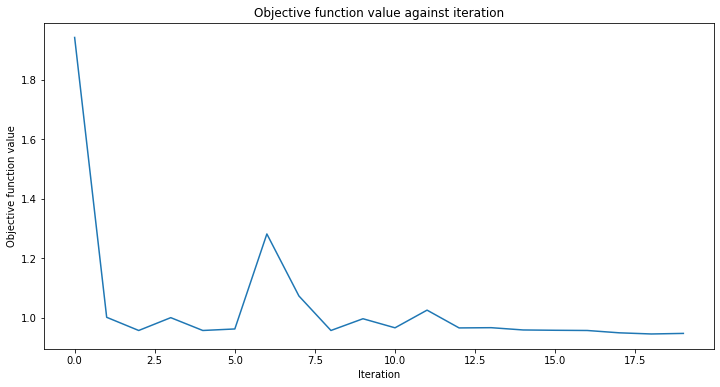

training score =  0.053886488942377464
test score =  0.055782681528698475


In [18]:
maxEvents=5000
MaxIter=20

loss='squared_error'
optimizer=COBYLA(maxiter=MaxIter)

estimator_regressor_rotPerm = NeuralNetworkRegressor(
    estimator_qnn_rotPerm, optimizer=optimizer ,callback=callback_graph,loss=loss
)


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
plt.grid()

# fit classifier to data
estimator_regressor_rotPerm.fit(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])

print("training score = ",estimator_regressor_rotPerm.score(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents]))
print("test score = ",estimator_regressor_rotPerm.score(X_test_dot[0:maxEvents], y_test_dot[0:maxEvents]))

In [19]:
def getBestTheshold(est,X_test,y_test):
    y_predict=est.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict, pos_label=1)

    bestValidation=0
    threshold_best=0
    for t in thresholds:
        y=y_predict.copy().flatten()
        y[y>t]=1
        y[y<t]=-1
        diff=y-y_test[0:maxEvents]
        val=diff[diff==0].shape[0]/y.shape[0]
        if val>bestValidation:
            bestValidation=val
            threshold_best=t
            print(val,threshold_best)
    return threshold_best

In [20]:
threshold_best=getBestTheshold(estimator_regressor_rotPerm,X_test_dot[0:maxEvents],y_test_dot[0:maxEvents])

0.5035 inf
0.5065 0.08623340116971831
0.5185 0.08594669087968365
0.536 0.08562302461938154
0.611 0.08404320725096182
0.621 0.0838236834464718
0.6215 0.08376229192455403
0.6325 0.08353880314793183
0.6355 0.08349169792187575
0.6385 0.08335042417037145
0.6405 0.08327495284543122
0.6705 0.08266863778283524
0.682 0.08249924975202572
0.697 0.08209881217586243
0.7255 0.08124700930867938
0.7285 0.08113394576977145
0.7445 0.08048686623033544
0.754 0.08005700921126443
0.7725 0.07945839000705712
0.7755 0.07926919972987384
0.789 0.07866507865528846
0.8105 0.07775277080310955
0.8355 0.07657682755117541
0.838 0.07631812355909794
0.8395 0.07615120462670771
0.8465 0.07520571431863984
0.8485 0.07351213300911853


0.5035 inf
0.5065 0.08623340116971831
0.5185 0.08594669087968365
0.536 0.08562302461938154
0.611 0.08404320725096182
0.621 0.0838236834464718
0.6215 0.08376229192455403
0.6325 0.08353880314793183
0.6355 0.08349169792187575
0.6385 0.08335042417037145
0.6405 0.08327495284543122
0.6705 0.08266863778283524
0.682 0.08249924975202572
0.697 0.08209881217586243
0.7255 0.08124700930867938
0.7285 0.08113394576977145
0.7445 0.08048686623033544
0.754 0.08005700921126443
0.7725 0.07945839000705712
0.7755 0.07926919972987384
0.789 0.07866507865528846
0.8105 0.07775277080310955
0.8355 0.07657682755117541
0.838 0.07631812355909794
0.8395 0.07615120462670771
0.8465 0.07520571431863984
0.8485 0.07351213300911853


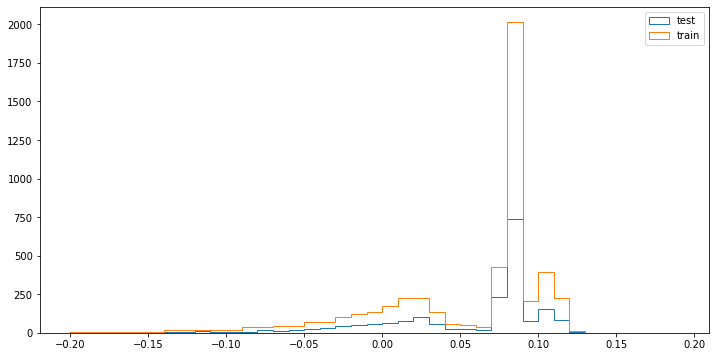

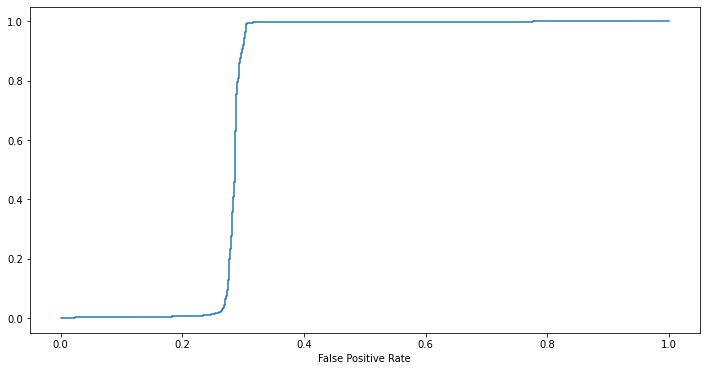

In [21]:
y_predict=estimator_regressor_rotPerm.predict(X_test_dot[0:maxEvents]).flatten()
train_predict=estimator_regressor_rotPerm.predict(X_train_dot[0:maxEvents]).flatten()
threshold_best=getBestTheshold(estimator_regressor_rotPerm,X_test_dot[0:maxEvents],y_test_dot[0:maxEvents])

plt.figure(1)
bins=np.arange(-0.2,0.2,0.01)
plt.hist(y_predict,bins=bins,histtype='step',label='test');
plt.hist(train_predict,bins=bins,histtype='step',label='train');
plt.legend()

plt.figure(2)
fpr, tpr, thresholds = metrics.roc_curve(y_train_dot[0:maxEvents], train_predict, pos_label=1)

plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")

plt.show()


# fpr, tpr, thresholds = metrics.roc_curve(y_test_dot[0:maxEvents], y_predict, pos_label=1)

# bestValidation=0
# threshold_best=0
# inv_dot_all=inv_dot_test[0:maxEvents]
# for t in thresholds:
#     y=y_predict.copy().flatten()
#     y[y>t]=1
#     y[y<t]=-1
#     diff=y-y_test_dot[0:maxEvents]
#     val=diff[diff==0].shape[0]/y.shape[0]
#     if val>bestValidation:
#         bestValidation=val
#         threshold_best=t
#         print(val,threshold_best)
        
#         inv_dot_wrong=inv_dot_all[diff!=0]
#         inv_dot_correct=inv_dot_all[diff==0]
        
#         X_test_dot_wrong=X_test_dot[np.where(diff!=0)[0]]
#         X_test_dot_correct=X_test_dot[np.where(diff==0)[0]]   
    

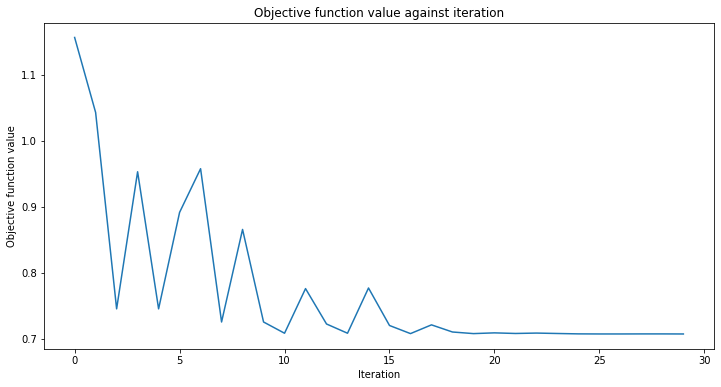

In [22]:
estimator_qnn_rotPerm2=getEstimator(2,4)

MaxIter=30

loss='squared_error'
optimizer=COBYLA(maxiter=MaxIter)

estimator_regressor_rotPerm2 = NeuralNetworkRegressor(
    estimator_qnn_rotPerm2, optimizer=optimizer ,callback=callback_graph,loss=loss
)


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
plt.grid()

# fit classifier to data
X_2=X_train_dot[0:maxEvents][train_predict>threshold_best]
y_2= y_train_dot[0:maxEvents][train_predict>threshold_best]

estimator_regressor_rotPerm2.fit(X_2, y_2)

In [23]:
y_predict2=estimator_regressor_rotPerm2.predict(X_2).flatten()
train_predict2=estimator_regressor_rotPerm2.predict(X_2).flatten()

In [24]:
train_predict2

array([0.50934896, 0.52538714, 0.52300788, ..., 0.51935074, 0.51912727,
       0.51952511])

0.23718932187787664 inf
0.24884934028843203 0.5299214596298518
0.2586683031604787 0.5291069506068384
0.2598956735194845 0.5288662624355444
0.26327094200675055 0.5287290488397753
0.263577784596502 0.5286520835021986
0.2786130714943234 0.5275219843695284
0.28843203436637005 0.5269437067436158
0.2973304694691623 0.5264259783745995
0.29763731205891375 0.5263664943360283
0.2988646824179196 0.5262432965758203
0.30285363608468857 0.5259856528958338
0.3040810064436944 0.5259175580480749
0.30622890457195456 0.5258274634720891
0.3142068119054925 0.5253688730488517
0.3148204970849954 0.5253216040307356
0.32218471923903036 0.5249121345206944
0.33108315434182267 0.5245502829098566
0.33261736729057995 0.5243657923840767
0.3341515802393372 0.5242470110422167
0.33599263577784594 0.5240956845818245
0.3451979134703897 0.52382720042012
0.3473458115986499 0.5237668314823671
0.35225529303467323 0.5235886981565016
0.3537895059834305 0.5234902964949288
0.35992635777845966 0.5232896208379905
0.369438478060754

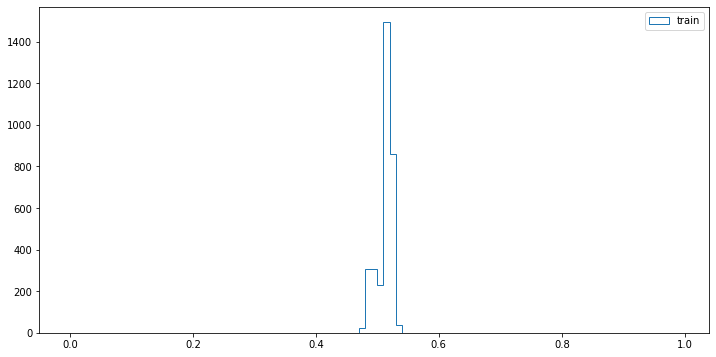

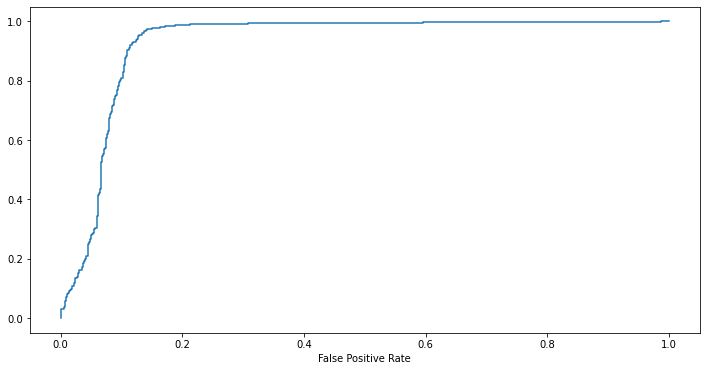

In [25]:
threshold_best2=getBestTheshold(estimator_regressor_rotPerm2,X_2,y_2)

plt.figure(1)
bins=np.arange(0,1,0.01)
plt.hist(train_predict2,bins=bins,histtype='step',label='train');
plt.legend()

plt.figure(2)
fpr, tpr, thresholds = metrics.roc_curve(y_2, train_predict2, pos_label=1)

plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")

plt.show()


In [42]:
#validation

x_test=X_test_dot[0:maxEvents]
y_test=y_test_dot[0:maxEvents]
y_predict=estimator_regressor_rotPerm.predict(x_test).flatten()
y_predict[y_predict<threshold_best]=-1

x_test_split=x_test[y_predict>threshold_best]
y_predict2=estimator_regressor_rotPerm2.predict(x_test_split).flatten()
y_predict2[y_predict2<threshold_best2]=-1
y_predict2[y_predict2>threshold_best2]=1
y_predict[y_predict>threshold_best]=y_predict2



In [47]:
y_predict

array([-1., -1., -1., ...,  1., -1.,  1.])

In [48]:
y_test

array([-1., -1., -1., ...,  1., -1.,  1.])

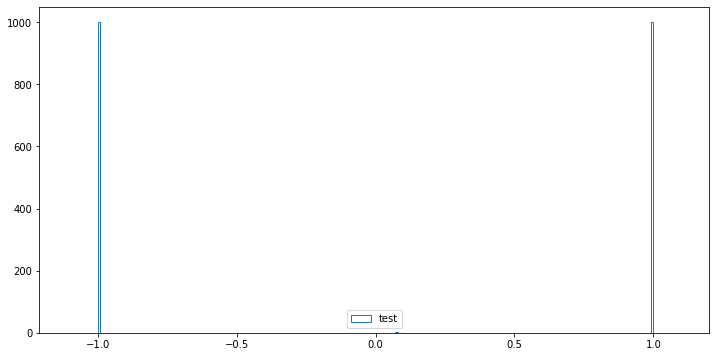

In [49]:
plt.figure(1)
bins=np.arange(-1.1,1.1,0.01)
plt.hist(y_predict,bins=bins,histtype='step',label='test');
plt.legend()



In [54]:
diff=y_predict-y_test
print(diff[diff==0].shape[0]/diff.shape[0])

0.9585


No symmetry

In [ ]:
nLayer_realAmplitude=2
num_qubits=X_3.shape[1]
n_inputParams=num_qubits
n_params=nLayer_realAmplitude*num_qubits
N_particles=4
print(num_qubits)



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_baseline.fit(X_train_3[0:maxEvents],y_train_3[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)


qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)

qc.compose(feature_map, inplace=True) 
qc.compose(ansatz,inplace=True)    

observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

estimator_classifier_baseline = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=MaxIter), callback=callback_graph
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_baseline.fit(X_train_3[0:maxEvents],y_train_3[0:maxEvents])

# score classifier
print("training score = ",estimator_classifier_baseline.score(X_train_3[0:maxEvents], y_train_3[0:maxEvents]))
print("test score = ",estimator_classifier_baseline.score(X_test_3[0:2*maxEvents], y_test_3[0:2*maxEvents]))


Rotation only

In [ ]:

num_layers=2
N_particles=4
num_qubits=int((N_particles+1)*N_particles/2)
n_params=num_layers*num_qubits
zeroState = '0'
for i in range(num_qubits-1):
    zeroState+='0'
def countZero(x):
    return f"{bin(x)}".count("0")%(num_qubits+1)

qr_rot = QuantumRegister(num_qubits)
qc_rot = QuantumCircuit(qr_rot)
feature_map_rot = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz_rot=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)


inputParams_index=0
params_index=0
qc_rot.compose(feature_map_rot, inplace=True) 
qc_rot.compose(ansatz_rot,inplace=True)    

observable1_rot = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn_rot = EstimatorQNN(
    circuit=qc_rot, observables=observable1_rot, input_params=feature_map_rot.parameters, weight_params=ansatz_rot.parameters
)
estimator_classifier_rot = NeuralNetworkClassifier(
    estimator_qnn_rot, optimizer=COBYLA(maxiter=MaxIter), callback=callback_graph
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_rot.fit(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])

print("training score = ",estimator_classifier_rot.score(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents]))
print("test score = ",estimator_classifier_rot.score(X_test_dot[0:2*maxEvents], y_test_dot[0:2*maxEvents]))


Rotation + Permutation

In [ ]:

num_layers=2
# n_inputParams=num_qubits
n_params=num_layers*2
N_particles=4
num_qubits=int((N_particles-1)*N_particles/2)

In [ ]:

qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")


weights = ParameterVector("weight", n_params)
print(f"weight parameters: {[str(item) for item in weights.params]}")

inputParams_index=0
params_index=0


qc.compose(feature_map, inplace=True) 
   
for layer in range(num_layers):
    
#         for i in range(N_particles):
#             qc.ry(weights[params_index],i)
            
#         params_index += 1 
        
#         for i in range(N_particles):
#             for k in np.arange(i,N_particles,1):
#                 if i!=k:
#                     qc.rzz(weights[params_index],i,k)
            
            
#         params_index += 1
#         for j in np.arange(N_particles,num_qubits,1):
#             qc.ry(weights[params_index],j)
#         params_index += 1
        
#         for i in np.arange(N_particles,num_qubits,1):
#             for k in np.arange(i,num_qubits,1):
#                 if i!=k:
#                     qc.rzz(weights[params_index],i,k)
                    
#         params_index += 1
        
        for j in np.arange(0,num_qubits,1):
            qc.ry(weights[params_index],j)
        
        params_index += 1
        
        for i in np.arange(0,num_qubits,1):
            for k in np.arange(i,num_qubits,1):
                if i!=k:
                    qc.rzz(weights[params_index],i,k)
                    
        params_index += 1
            
        
        qc.barrier()

In [ ]:
qc.draw('mpl')

In [ ]:
MaxIter=30
maxEvents=1000

observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
)

estimator_classifier_rotPerm = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=MaxIter), callback=callback_graph
)

In [ ]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


# fit classifier to data
estimator_classifier_rotPerm.fit(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)
# score classifier
print("training score = ",estimator_classifier_rotPerm.score(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents]))
print("test score = ",estimator_classifier_rotPerm.score(X_test_dot[0:maxEvents], y_test_dot[0:maxEvents]))

In [ ]:
#regressor:

In [ ]:

num_layers=2
# n_inputParams=num_qubits
n_params=num_layers*2
N_particles=4
num_qubits=int((N_particles-1)*N_particles/2)

qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")


weights = ParameterVector("weight", n_params)
print(f"weight parameters: {[str(item) for item in weights.params]}")

inputParams_index=0
params_index=0

qc.compose(feature_map, inplace=True) 
   
for layer in range(num_layers):

        for j in np.arange(0,num_qubits,1):
            qc.ry(weights[params_index],j)
        
        params_index += 1
        
        for i in np.arange(0,num_qubits,1):
            for k in np.arange(i,num_qubits,1):
                if i!=k:
                    qc.rzz(weights[params_index],i,k)
                    
        params_index += 1
        
        qc.barrier()

observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn_rotPerm = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
)


loss='squared_error'


optimizer=COBYLA(maxiter=MaxIter)

estimator_regressor_rotPerm = NeuralNetworkRegressor(
    estimator_qnn_rotPerm, optimizer=optimizer ,callback=callback_graph,loss=loss
)


In [ ]:
maxEvents=500
MaxIter=30

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
plt.grid()

# fit classifier to data
estimator_regressor_rotPerm.fit(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])

print("training score = ",estimator_regressor_rotPerm.score(X_train_dot[0:maxEvents], y_train_dot[0:maxEvents]))
print("test score = ",estimator_regressor_rotPerm.score(X_test_dot[0:maxEvents], y_test_dot[0:maxEvents]))

In [ ]:
y_predict=estimator_regressor_rotPerm.predict(X_test_dot[0:maxEvents])
fpr, tpr, thresholds = metrics.roc_curve(y_test_dot[0:maxEvents], y_predict, pos_label=1)

bestValidation=0
inv_dot_all=inv_dot_test[0:maxEvents]
for t in thresholds:
    y=y_predict.copy().flatten()
    y[y>t]=1
    y[y<t]=-1
    diff=y-y_test_dot[0:maxEvents]
    val=diff[diff==0].shape[0]/y.shape[0]
    if val>bestValidation:
        bestValidation=val
        print(val)
        
        inv_dot_wrong=inv_dot_all[diff!=0]
        inv_dot_correct=inv_dot_all[diff==0]
        
        X_test_dot_wrong=X_test_dot[np.where(diff!=0)[0]]
        X_test_dot_correct=X_test_dot[np.where(diff==0)[0]]
        
    

In [ ]:
train_predict=estimator_regressor_rotPerm.predict(X_train_dot[0:maxEvents])
bins=np.arange(-0.2,0.2,0.01)
plt.hist(y_predict,bins=bins,histtype='step',label='test');

plt.hist(train_predict,bins=bins,histtype='step',label='train');
plt.legend()

In [ ]:
bins=np.arange(-0.2,0.2,0.01)
plt.hist(y_predict,bins=bins,histtype='step',label='test');

plt.hist(train_predict,bins=bins,histtype='step',label='train');
plt.legend()

In [ ]:
plt.hist(inv_dot_wrong,bins=np.arange(0,400,10),histtype='step',label='Wrongly labeled');
plt.hist(inv_dot_correct,bins=np.arange(0,400,10),histtype='step',label='Correctly labeled');
plt.legend()

In [ ]:
plt.hist((X_test_dot_wrong*1593.626863377703).max(axis=1),histtype='step',bins=np.arange(0,100,5));
plt.hist((X_test_dot_correct*1593.626863377703).max(axis=1),histtype='step',bins=np.arange(0,100,5));



In [ ]:
plt.hist((X_test_dot_wrong*1593.626863377703).sum(axis=1),histtype='step',bins=np.arange(0,1000,5));
plt.hist((X_test_dot_correct*1593.626863377703).sum(axis=1),histtype='step',bins=np.arange(0,1000,5));



In [ ]:
(X_test_dot_correct*1593.626863377703)

In [ ]:
3(X_test_dot_wrong*1593.626863377703)

In [ ]:
plt.hist(y_predict,bins=np.linspace(-1,1,100));


In [ ]:
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()

In [ ]:
#classical 4vec

In [ ]:
from keras import utils 
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import sklearn.neural_network as skl_nn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate 


In [ ]:

def getFourVectors_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    

    output=np.concatenate([v1,v2,v3,v4])
    return  np.transpose(output)

sig_4vec=getFourVectors_df(h4l)
bkg_4vec=getFourVectors_df(bkg)

X_4=np.concatenate([sig_4vec[0:maxDatasetEvents],bkg_4vec[0:maxDatasetEvents]])

maxEvents=5000
n_neurons=10

X_onehot=np.concatenate([sig_4vec[0:maxDatasetEvents],bkg_4vec[0:maxDatasetEvents]])
y_onehot=np.concatenate([np.ones(sig_4vec[0:maxDatasetEvents].shape[0]),np.zeros(bkg_4vec[0:maxDatasetEvents].shape[0])])
y_onehot= utils.to_categorical(y_onehot, 2)
X_onehot,y_onehot=shuffle(X_onehot,y_onehot,random_state=1000)


In [ ]:
n_neurons_list=[2,3,4,5,10,50]
validation_list=[]
nParams_list=[]

for n_neurons in n_neurons_list:
    print("starting ",n_neurons)
    mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(n_neurons,n_neurons),early_stopping=True, 
                           validation_fraction=0.2,max_iter=10000, verbose=0, random_state=10,
                          n_iter_no_change=1000)
    mlp.fit(X_onehot[0:maxEvents],y_onehot[0:maxEvents])
    best_validation=mlp.best_validation_score_ 
    n_params=X_onehot.shape[1]*n_neurons+(n_neurons**2)*3+n_neurons
    
    validation_list.append(best_validation)
    nParams_list.append(n_params)
    print("best_validation = ",best_validation)

    print("finishing ",n_neurons)

In [ ]:
plt.plot(nParams_list,validation_list)
plt.xlabel('number of parameters')
plt.ylabel('best validation score')
plt.xscale('log')

In [ ]:
X_onehot.shape[1]

In [ ]:
#classical lorentz

In [ ]:
X_dot_onehot=np.concatenate([sig_dot[0:maxDatasetEvents],bkg_dot[0:maxDatasetEvents]])
y_dot_onehot=np.concatenate([np.ones(sig_4vec[0:maxDatasetEvents].shape[0]),np.zeros(bkg_4vec[0:maxDatasetEvents].shape[0])])

X_dot_onehot,y_dot_onehot=shuffle(X_dot_onehot,y_dot_onehot,random_state=1000)

In [ ]:
#single:


n_neurons_list=[1]

validation_list=[]
validation_list_error=[]
nParams_list=[]

for i in range(len(n_neurons_list)):
    
    tmp_validation_list=[]
    for j in range(10):
        mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(n_neurons_list[i]),early_stopping=True, 
                                   validation_fraction=0.2,max_iter=10000, verbose=0,
                                  n_iter_no_change=1000)
        mlp.fit(X_dot_onehot[0:maxEvents],y_dot_onehot[0:maxEvents])
        best_validation=mlp.best_validation_score_ 
        tmp_validation_list.append(best_validation)
        
    tmp_validation_list=np.array(tmp_validation_list)
    n_params=X_onehot.shape[1]*n_neurons_list[i]+n_neurons_list[i]
    
    validation_list.append(tmp_validation_list.mean())
    validation_list_error.append(tmp_validation_list.std())
    nParams_list.append(n_params)
    print("nparams =",n_params,"best_validation = ",tmp_validation_list.mean(),"error = ",tmp_validation_list.std())

    print("finishing ",n_neurons)

In [ ]:
#One layer:


n_neurons_list=[2,3,4,5,10]

validation_list=[]
validation_list_error=[]
nParams_list=[]

for i in range(len(n_neurons_list)):
    
    tmp_validation_list=[]
    for j in range(10):
        mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(n_neurons_list[i]),early_stopping=True, 
                                   validation_fraction=0.2,max_iter=10000, verbose=0,
                                  n_iter_no_change=2000)
        mlp.fit(X_dot_onehot[0:maxEvents],y_dot_onehot[0:maxEvents])
        best_validation=mlp.best_validation_score_ 
        tmp_validation_list.append(best_validation)
        
    tmp_validation_list=np.array(tmp_validation_list)
    n_params=X_onehot.shape[1]*n_neurons_list[i]+n_neurons_list[i]
    
    validation_list.append(tmp_validation_list.mean())
    validation_list_error.append(tmp_validation_list.std())
    nParams_list.append(n_params)
    print("nparams =",n_params,"best_validation = ",tmp_validation_list.mean(),"error = ",tmp_validation_list.std())

    print("finishing ",n_neurons)

In [ ]:
#twolayers:


n_neurons_list=[1,2,3,4,5]

validation_list=[]
validation_list_error=[]
nParams_list=[]

for i in range(len(n_neurons_list)):
    
    tmp_validation_list=[]
    for j in range(10):
        mlp = skl_nn.MLPClassifier(hidden_layer_sizes=(2,n_neurons_list[i]),early_stopping=True, 
                                   validation_fraction=0.2,max_iter=10000, verbose=0,
                                  n_iter_no_change=2000)
        mlp.fit(X_dot_onehot[0:maxEvents],y_dot_onehot[0:maxEvents])
        best_validation=mlp.best_validation_score_ 
        tmp_validation_list.append(best_validation)
        
    tmp_validation_list=np.array(tmp_validation_list)
    n_params=n_params=X_onehot.shape[1]*2+2+(n_neurons_list[i]*2)
    
    validation_list.append(tmp_validation_list.mean())
    validation_list_error.append(tmp_validation_list.std())
    nParams_list.append(n_params)
    print("nparams =",n_params,"best_validation = ",tmp_validation_list.mean(),"error = ",tmp_validation_list.std())

    print("finishing ",n_neurons)